In [79]:
# !git clone https://github.com/DenisPerez/NN_Tests_DG.git
# %cd NN_Tests_DG
# %ls

## CIFAR 10 notebook for TEG


## Importamos las librerias necesarias

In [80]:
import numpy as np
import matplotlib.pyplot as plt

#PyTorch stuff
import torch
torch.manual_seed(0) # => importante para replicar los experimentos. Setea la semilla para la generacion de numeros aleatorios
from torch import optim, nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset, random_split

from classes import CyclicLRGiselt_Denis
import random

## Usamos la GPU en caso de estar disponible


In [81]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


##  Datasets y Dataloaders

In [82]:
PATH = './Dataset/cifar-10' # Path en donde queramos colocar le Dataset
TRAIN_SIZE = 50000 # Tamano del set de entrenamiento
VAL_SIZE = 5000 # Tamano del set de validacion
TEST_SIZE = 5000 #Tamano del set de pruebas
MINIBATCH_SIZE = 512 #Tamano del minibatch

#T.Compose hace que al generar cada minibatch se aplique la serie de transformaciones descritas
transform_cifar10_train = T.Compose([
                T.RandomHorizontalFlip(p=0.3), #Con probabilidad de 0.3 (30%) hara un flip horizontal sobre el set de entrenamiento
                T.ColorJitter(brightness=0.1, contrast=0.1, hue = 0.05), # Realice ajustes de brillo, contraste y ajuste de color
                T.RandomApply([T.RandomRotation(10), #Rotacion de 10 grados
                               T.Resize(40), #Hacemos aumento de la imagen a 40x40 pixeles
                               T.CenterCrop(32)], #Recortamos los 32 pixeles del centro de la imagens
                               p = 0.1), #Probabilidad de realizar esto
                T.ToTensor(), #Convertimos a Tensor
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262]) #Medias y desviaciones estandar para cada canal RGB de CIFAR 10 https://github.com/facebookarchive/fb.resnet.torch/issues/180
            ])
transform_cifar10_test = T.Compose([
                T.ToTensor(), #Convertimos a Tensor
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262]) #Medias y desviaciones estandar para cada canal RGB de CIFAR 10 https://github.com/facebookarchive/fb.resnet.torch/issues/180
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(PATH, 
                                train=True, 
                                download=True,
                                transform=transform_cifar10_train) #Descargamos el set de entrenamiento en caso de no tenerlo
train_loader = DataLoader(cifar10_train, 
                          batch_size=MINIBATCH_SIZE, 
                          shuffle = True) #Creamos el dataloader. El dataloader permite tener un iterable (x,y) sobre el set de CIFAR 10

# Validation and test sets
test_dataset = datasets.CIFAR10(PATH, 
                                train=False, 
                                download=True, 
                                transform=transform_cifar10_test) #Descargamos datos de prueba
val_dataset, test_dataset = random_split(test_dataset, [VAL_SIZE, TEST_SIZE]) #Hacemos un spit random para validacion y test

val_loader = DataLoader(val_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

test_loader = DataLoader(test_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [83]:
for i,(x, y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

0 torch.Size([512, 3, 32, 32]) torch.Size([512])
1 torch.Size([512, 3, 32, 32]) torch.Size([512])
2 torch.Size([512, 3, 32, 32]) torch.Size([512])
3 torch.Size([512, 3, 32, 32]) torch.Size([512])
4 torch.Size([512, 3, 32, 32]) torch.Size([512])
5 torch.Size([512, 3, 32, 32]) torch.Size([512])
6 torch.Size([512, 3, 32, 32]) torch.Size([512])
7 torch.Size([512, 3, 32, 32]) torch.Size([512])
8 torch.Size([512, 3, 32, 32]) torch.Size([512])
9 torch.Size([392, 3, 32, 32]) torch.Size([392])


### Mostrar datos

La imagen muestreada representa un: cat


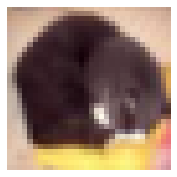

In [84]:
classes = train_loader.dataset.classes
def plot_figure(image):
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

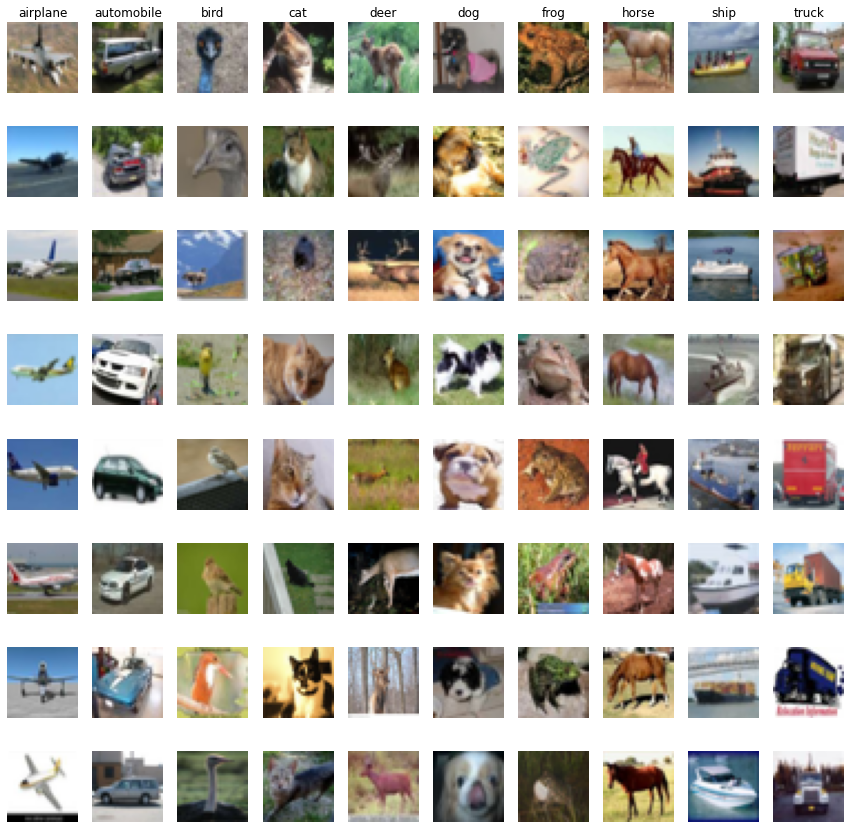

In [85]:
def plot_cifar10_grid():
    classes = train_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(train_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(train_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 


#### Accuracy

In [86]:
len(val_loader)

10

In [87]:
def accuracy(model, loader):
    '''
    model - PyTorch model
    loader - PyTorch dataloader
    
    Returns:
    
    '''
    correct = 0
    total = 0
    cost = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            _, pred = scores.max(dim=1)
            correct += (pred == y).sum()
            total += pred.size(0)
        #Aca agregue retornar el costo tambien para poder saber la funcion de costo para el set de test o validacion
        return cost/len(val_loader), float(correct)/total

#### Buscar learning rate

In [88]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0)) 
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
        
#         accuracies.append(acc.item())
        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

### Loop de Entrenamiento

In [89]:
def train(model, optimiser, scheduler = None, epochs = 100):
    model = model.to(device = device)
    i = 0
    val_loss_history = []
    train_loss_history = []
    val_acc_history = []
    train_acc_history = []
    lrs = []
    train_cost = 0.
    val_cost = 0.
    val_acc = 0.
    train_cost_acum = 0
    for epoch in range(epochs):
        if(val_acc >= 0.95):
            break;
        train_correct_num  = 0
        train_total = 0
        train_cost_acum = 0
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)        
            train_acc = float(train_correct_num)/train_total  
            train_acc_history.append(train_acc)
            train_acc = float(train_correct_num)/train_total
            train_cost_acum += cost.item()
            train_cost = train_cost_acum/len(train_loader)
            train_loss_history.append(cost.item())
        #if using scheduler
        if scheduler: 
            scheduler.step()
            lr = scheduler.get_last_lr()[0]
        else:
            lr = optimiser.param_groups[0]["lr"]
        val_cost, val_acc = accuracy(model, val_loader)

        val_loss_history.append(val_cost)
        val_acc_history.append(val_acc)
        lrs.append(lr)
        i+=i
        
        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}, total: {train_total},'
                      f' lr: {lr:.6f}')
        
    return val_acc_history,val_loss_history, lrs, i

# ResNet56
https://arxiv.org/pdf/1512.03385.pdf

In [90]:
conv_k_3 = lambda channel1, channel2, stride: nn.Conv2d(channel1, channel2, stride = stride, kernel_size=3, padding=1)

In [91]:
class residual_block(nn.Module):
    '''

    '''
    def __init__(self, in_channel, out_channel, stride=1, change_size = True):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, out_channel, stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = conv_k_3(out_channel, out_channel, 1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        #for changing activation map sizes
        self.change_size = change_size
        if change_size:
            self.residual = nn.Sequential(nn.Conv2d(in_channel, 
                                                    out_channel, 
                                                    kernel_size=1,
                                                    stride=stride),
                                         nn.BatchNorm2d(out_channel)
                                         )      
    def forward(self, x):
        identity = x if not self.change_size else self.residual(x)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += identity
        return F.relu(y)


In [92]:
class ResNet56(nn.Module):
    def __init__(self, n=9, num_classes=10):
        super().__init__()
        self.conv1 = conv_k_3(3, 16, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.block1 = self.create_block(n=9, in_channel=16, 
                                        out_channel=16, stride=1, 
                                        change_size=False)
        self.block2 = self.create_block(n=9, in_channel=16, 
                                        out_channel=32, stride=2)
        self.block3 = self.create_block(n=9, in_channel=32, 
                                        out_channel=64, stride=2)
        self.fc = nn.Linear(64, num_classes)

    def create_block(self, n, in_channel, out_channel, stride, change_size=True):
        block = [residual_block(in_channel, out_channel, stride, change_size=change_size)]
        for i in range(n-1):
            block.append(residual_block(out_channel, out_channel, stride=1, change_size=False))
        return nn.Sequential(*block)   
        
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.block3(self.block2(self.block1(y)))
        y = F.adaptive_avg_pool2d(y, 1)
        return self.fc(y.view(y.size(0), -1))      
       
        

## Lo que estaba antes


In [93]:
# lg_lr, losses, accuracies = find_lr(model_resnet56, 
#                                     optimizer,
#                                     start_val=1e-6, 
#                                     end_val=10)

In [94]:
# f1, ax1 = plt.subplots(figsize=(20,10))
# # ax1.plot(lr[60:-2], losses[60:-2])
# ax1.plot(lg_lr, losses)
# ax1.set_xscale('log')
# ax1.set_xticks([1e-1,2e-1, 1, 10])
# ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
# plt.show()

In [95]:
# f1, ax1 = plt.subplots(figsize=(20,10))
# # ax1.plot(lr[60:-2], losses[60:-2])
# ax1.plot(lg_lr, accuracies)
# ax1.set_xscale('log')
# # ax1.set_xticks([1e-1, 2e-1,5e-1, 7e-1, 1, 10])
# ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
# plt.show()

# Experimentos

## Variables Globales

In [96]:
MAX_ITERATIONS = 1
EPOCHS = 20
layer1 = 1000 
layer2 = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
input_layer = 784
first_i = 0

resultados = {}

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

## List Functions

In [97]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first[::-1], second[::-1])][::-1]

def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda num: num != 0, dic_list))

## Adam 

In [98]:

def Adam():
    modelAdam = ResNet56()
    optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))
    start.record()
    adam_acc_list, adam_cost_list,adam_lr_list, adam_epochs = train(modelAdam,optimiserAdam,None, EPOCHS)
    end.record()


    torch.cuda.synchronize()
    adam_time = start.elapsed_time(end)

    adam_acc = accuracy(modelAdam, test_loader)

    return adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs

resultados['adam'] = {}
resultados['adam']['val_acc_list'] = [0] * epochs
resultados['adam']['test_acc'] = 0
resultados['adam']['cost'] = [0] * epochs
resultados['adam']['time'] = 0
resultados['adam']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs = Adam()
    resultados['adam']['val_acc_list'] = SumList(resultados['adam']['val_acc_list'], adam_acc_list)
    resultados['adam']['test_acc'] += adam_acc[1]
    resultados['adam']['cost'] = SumList(resultados['adam']['cost'], adam_cost_list)
    resultados['adam']['time'] += adam_time
    resultados['adam']['epochs'] += adam_epochs

#Saving results
resultados['adam']['name'] = 'Adam'
resultados['adam']['lr'] = adam_lr_list
resultados['adam']['test_acc'] = resultados['adam']['test_acc'] / MAX_ITERATIONS
resultados['adam']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['adam']['val_acc_list'], MAX_ITERATIONS))
resultados['adam']['cost'] = DeleteZerosFromList(DivideList(resultados['adam']['cost'], MAX_ITERATIONS))
resultados['adam']['time'] = resultados['adam']['time']
resultados['adam']['epochs'] = resultados['adam']['epochs'] / MAX_ITERATIONS


Epoch:0, train cost: 1.947342, val cost: 1.709329, train acc: 0.2743, val acc: 0.347200, total: 50000, lr: 0.010000
Epoch:1, train cost: 1.533726, val cost: 1.451789, train acc: 0.4341, val acc: 0.472400, total: 50000, lr: 0.010000
Epoch:2, train cost: 1.338800, val cost: 1.355189, train acc: 0.5111, val acc: 0.507000, total: 50000, lr: 0.010000
Epoch:3, train cost: 1.110415, val cost: 1.111496, train acc: 0.6024, val acc: 0.612800, total: 50000, lr: 0.010000
Epoch:4, train cost: 0.929460, val cost: 1.131371, train acc: 0.6710, val acc: 0.635000, total: 50000, lr: 0.010000
Epoch:5, train cost: 0.801451, val cost: 0.835594, train acc: 0.7184, val acc: 0.719400, total: 50000, lr: 0.010000
Epoch:6, train cost: 0.705412, val cost: 0.778473, train acc: 0.7543, val acc: 0.738800, total: 50000, lr: 0.010000
Epoch:7, train cost: 0.633275, val cost: 0.768696, train acc: 0.7797, val acc: 0.741400, total: 50000, lr: 0.010000
Epoch:8, train cost: 0.573182, val cost: 0.684584, train acc: 0.8023, va

## Decreciente (propio) con Momentum

In [99]:

def Our_Decay():
    modelOurDecay = ResNet56()
    optimizer = torch.optim.SGD(modelOurDecay.parameters(), lr=1, momentum=0.9)


    clr_fn = lambda x, y: random.uniform(x, y)
    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.0001, max_lr=0.1,scale_fn=clr_fn, step_size_up=1,scale_mode='decrecimiento', cycle_momentum=False)

    start.record()
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_epochs = train(modelOurDecay,optimizer, scheduler,EPOCHS)
    end.record()

    torch.cuda.synchronize()
    our_decay_time = start.elapsed_time(end)

    our_decay_acc = accuracy(modelOurDecay, test_loader)

    return our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs

resultados['our_decay'] = {}
resultados['our_decay']['val_acc_list'] = [0] * epochs
resultados['our_decay']['test_acc'] = 0
resultados['our_decay']['cost'] = [0] * epochs
resultados['our_decay']['time'] = 0
resultados['our_decay']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs = Our_Decay()
    resultados['our_decay']['val_acc_list'] = SumList(resultados['our_decay']['val_acc_list'], our_decay_acc_list)
    resultados['our_decay']['test_acc'] += our_decay_acc[1]
    resultados['our_decay']['cost'] = SumList(resultados['our_decay']['cost'], our_decay_cost_list)
    resultados['our_decay']['time'] += our_decay_time
    resultados['our_decay']['epochs'] += our_decay_epochs

#Saving results
resultados['our_decay']['name'] = 'Nuestro decreciente con Momentum'
resultados['our_decay']['lr'] = our_decay_lr_list
resultados['our_decay']['test_acc'] = resultados['our_decay']['test_acc'] / MAX_ITERATIONS
resultados['our_decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['our_decay']['val_acc_list'], MAX_ITERATIONS))
resultados['our_decay']['cost'] = DeleteZerosFromList(DivideList(resultados['our_decay']['cost'], MAX_ITERATIONS))
resultados['our_decay']['time'] = resultados['our_decay']['time'] 
resultados['our_decay']['epochs'] = resultados['our_decay']['epochs'] / MAX_ITERATIONS


Epoch:0, train cost: 2.180772, val cost: 1.855294, train acc: 0.2094, val acc: 0.291800, total: 50000, lr: 0.099900
Epoch:1, train cost: 1.663540, val cost: 1.500010, train acc: 0.3813, val acc: 0.440000, total: 50000, lr: 0.099800
Epoch:2, train cost: 1.407701, val cost: 1.640628, train acc: 0.4821, val acc: 0.443600, total: 50000, lr: 0.099700
Epoch:3, train cost: 1.211431, val cost: 1.178899, train acc: 0.5630, val acc: 0.590200, total: 50000, lr: 0.099600
Epoch:4, train cost: 1.052522, val cost: 0.976185, train acc: 0.6248, val acc: 0.649800, total: 50000, lr: 0.099500
Epoch:5, train cost: 0.909131, val cost: 0.815423, train acc: 0.6791, val acc: 0.714200, total: 50000, lr: 0.099400
Epoch:6, train cost: 0.788013, val cost: 0.932368, train acc: 0.7239, val acc: 0.678600, total: 50000, lr: 0.099300
Epoch:7, train cost: 0.725631, val cost: 0.790113, train acc: 0.7471, val acc: 0.731600, total: 50000, lr: 0.099200
Epoch:8, train cost: 0.658952, val cost: 0.766314, train acc: 0.7717, va

## Ciclico con Momentum

In [100]:

def CyclicMomentum():
    modelCyclicMomentum = ResNet56()
    optimizer = torch.optim.SGD(modelCyclicMomentum.parameters(), lr=lr, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3,cycle_momentum=False )

    start.record()
    cyclicMomentum_acc_list, cyclicMomentum_cost_list, cyclicMomentum_lr_list, cyclicMomentum_epochs = train(modelCyclicMomentum, optimizer,scheduler, EPOCHS)
    end.record()

    torch.cuda.synchronize()
    cyclicMomentum_time = start.elapsed_time(end)

    cyclicMomentum_acc = accuracy(modelCyclicMomentum, test_loader)

    return cyclicMomentum_acc_list, cyclicMomentum_cost_list, cyclicMomentum_lr_list, cyclicMomentum_time, cyclicMomentum_acc, cyclicMomentum_epochs

resultados['cyclicMomentum'] = {}
resultados['cyclicMomentum']['val_acc_list'] = [0]* epochs
resultados['cyclicMomentum']['test_acc'] = 0
resultados['cyclicMomentum']['cost'] = [0] * epochs
resultados['cyclicMomentum']['time'] = 0
resultados['cyclicMomentum']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    cyclicMomentum_acc_list, cyclicMomentum_cost_list, cyclicMomentum_lr_list, cyclicMomentum_time, cyclicMomentum_acc, cyclicMomentum_epochs = CyclicMomentum()
    resultados['cyclicMomentum']['val_acc_list'] = SumList(resultados['cyclicMomentum']['val_acc_list'], cyclicMomentum_acc_list)
    resultados['cyclicMomentum']['test_acc'] += cyclicMomentum_acc[1]
    resultados['cyclicMomentum']['cost'] = SumList(resultados['cyclicMomentum']['cost'], cyclicMomentum_cost_list)
    resultados['cyclicMomentum']['time'] += cyclicMomentum_time
    resultados['cyclicMomentum']['epochs'] += cyclicMomentum_epochs

#Saving results
resultados['cyclicMomentum']['name'] = 'Ciclico Con Momentum'
resultados['cyclicMomentum']['lr'] = cyclicMomentum_lr_list
resultados['cyclicMomentum']['test_acc'] = resultados['cyclicMomentum']['test_acc'] / MAX_ITERATIONS
resultados['cyclicMomentum']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['cyclicMomentum']['val_acc_list'], MAX_ITERATIONS))
resultados['cyclicMomentum']['cost'] = DeleteZerosFromList(DivideList(resultados['cyclicMomentum']['cost'], MAX_ITERATIONS))
resultados['cyclicMomentum']['time'] = resultados['cyclicMomentum']['time']
resultados['cyclicMomentum']['epochs'] = resultados['cyclicMomentum']['epochs'] / MAX_ITERATIONS


Epoch:0, train cost: 1.748638, val cost: 1.475123, train acc: 0.3454, val acc: 0.454400, total: 50000, lr: 0.040000
Epoch:1, train cost: 1.432228, val cost: 1.458031, train acc: 0.4762, val acc: 0.524800, total: 50000, lr: 0.070000
Epoch:2, train cost: 1.093760, val cost: 1.036259, train acc: 0.6107, val acc: 0.645600, total: 50000, lr: 0.100000
Epoch:3, train cost: 0.890552, val cost: 0.889573, train acc: 0.6879, val acc: 0.702400, total: 50000, lr: 0.070000
Epoch:4, train cost: 0.685600, val cost: 0.786121, train acc: 0.7620, val acc: 0.736600, total: 50000, lr: 0.040000
Epoch:5, train cost: 0.560958, val cost: 0.660754, train acc: 0.8060, val acc: 0.779800, total: 50000, lr: 0.010000
Epoch:6, train cost: 0.468840, val cost: 0.511041, train acc: 0.8373, val acc: 0.828200, total: 50000, lr: 0.040000
Epoch:7, train cost: 0.499273, val cost: 0.707558, train acc: 0.8254, val acc: 0.762800, total: 50000, lr: 0.070000
Epoch:8, train cost: 0.535246, val cost: 0.630360, train acc: 0.8142, va

## Ciclico aleatorio con Momentum

In [101]:

def CyclicGD_Momentum():
    import random
    modelRandomCyclic_Momentum= ResNet56()
    optimizer = torch.optim.SGD(modelRandomCyclic_Momentum.parameters(), lr=lr, momentum=0.9)

    clr_fn = lambda x, y: random.uniform(x, y)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=2e-1,step_size_up=2, scale_fn=clr_fn,scale_mode='chipichipi', cycle_momentum=False)

    start.record()
    random_cyclic_Momentum_acc_list, random_cyclic_Momentum_cost_list, random_cyclic_Momentum_lr_list, random_cyclic_epochs= train(modelRandomCyclic_Momentum, optimizer,scheduler, EPOCHS)
    end.record()

    torch.cuda.synchronize()
    random_cyclic_Momentum_time = start.elapsed_time(end)

    random_cyclic_Momentum_acc = accuracy(modelRandomCyclic_Momentum, test_loader) 

    return random_cyclic_Momentum_acc_list, random_cyclic_Momentum_cost_list, random_cyclic_Momentum_lr_list, random_cyclic_Momentum_time, random_cyclic_Momentum_acc, random_cyclic_epochs
resultados['random_cyclic_Momentum'] = {}
resultados['random_cyclic_Momentum']['val_acc_list'] = [0] * epochs
resultados['random_cyclic_Momentum']['test_acc'] = 0
resultados['random_cyclic_Momentum']['cost'] = [0] * epochs
resultados['random_cyclic_Momentum']['time'] = 0
resultados['random_cyclic_Momentum']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    random_cyclic_Momentum_acc_list, random_cyclic_Momentum_cost_list, random_cyclic_Momentum_lr_list, random_cyclic_Momentum_time, random_cyclic_Momentum_acc, random_cyclic_epochs = CyclicGD_Momentum()
    a = SumList(resultados['random_cyclic_Momentum']['val_acc_list'], random_cyclic_Momentum_acc_list)
    resultados['random_cyclic_Momentum']['val_acc_list'] = SumList(resultados['random_cyclic_Momentum']['val_acc_list'], random_cyclic_Momentum_acc_list)
    resultados['random_cyclic_Momentum']['test_acc'] += random_cyclic_Momentum_acc[1]
    resultados['random_cyclic_Momentum']['cost'] = SumList(resultados['random_cyclic_Momentum']['cost'], random_cyclic_Momentum_cost_list)
    resultados['random_cyclic_Momentum']['time'] += random_cyclic_Momentum_time
    resultados['random_cyclic_Momentum']['epochs'] += random_cyclic_epochs

#Saving results
resultados['random_cyclic_Momentum']['name'] = 'Random Ciclico con Momentum'
resultados['random_cyclic_Momentum']['lr'] = random_cyclic_Momentum_lr_list
resultados['random_cyclic_Momentum']['test_acc'] = resultados['random_cyclic_Momentum']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic_Momentum']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_Momentum']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic_Momentum']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_Momentum']['cost'], MAX_ITERATIONS))
resultados['random_cyclic_Momentum']['time'] = resultados['random_cyclic_Momentum']['time']
resultados['random_cyclic_Momentum']['epochs'] = resultados['random_cyclic_Momentum']['epochs'] / MAX_ITERATIONS


Epoch:0, train cost: 2.014427, val cost: 1.694264, train acc: 0.2657, val acc: 0.367600, total: 50000, lr: 0.094367
Epoch:1, train cost: 1.576621, val cost: 1.561766, train acc: 0.4146, val acc: 0.441600, total: 50000, lr: 0.096062
Epoch:2, train cost: 1.349115, val cost: 1.336355, train acc: 0.5090, val acc: 0.518200, total: 50000, lr: 0.016049
Epoch:3, train cost: 1.127765, val cost: 1.081215, train acc: 0.5931, val acc: 0.608200, total: 50000, lr: 0.012613
Epoch:4, train cost: 1.036414, val cost: 0.990358, train acc: 0.6282, val acc: 0.650800, total: 50000, lr: 0.049640
Epoch:5, train cost: 1.040515, val cost: 0.990627, train acc: 0.6279, val acc: 0.647400, total: 50000, lr: 0.068485
Epoch:6, train cost: 0.988286, val cost: 0.912906, train acc: 0.6491, val acc: 0.675800, total: 50000, lr: 0.047572
Epoch:7, train cost: 0.849013, val cost: 0.957818, train acc: 0.6993, val acc: 0.668000, total: 50000, lr: 0.040871
Epoch:8, train cost: 0.777574, val cost: 0.838794, train acc: 0.7261, va

# Resultados

In [102]:
for key, _ in resultados.items():
    if( resultados[key]['val_acc_list'][0] == 0 ):
        continue
    resultados[key]['val_acc_list'].insert(0,0)

In [103]:
resultados['adam']['cost']

[1.7093286395072937,
 1.4517892241477965,
 1.355188536643982,
 1.1114961981773377,
 1.1313709378242494,
 0.8355944216251373,
 0.7784733355045319,
 0.7686960279941559,
 0.6845838308334351,
 0.7064146041870117,
 0.8560027956962586,
 0.5619661867618561,
 0.55109144449234,
 0.6469062030315399,
 0.628369152545929,
 0.6816006481647492,
 0.4879542887210846,
 0.49878676533699035,
 0.551099094748497,
 0.47590546011924745]

In [104]:
import pandas as pd
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
resultados_df['epochs'] = resultados_df.apply(lambda row: len(row['val_acc_list']), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

resultados_df = resultados_df.sort_values(by=['test_acc'],ascending=False)

## Comparacion de precisiones

In [105]:
resultados_df[['name','test_acc','val_acc', 'epochs']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_30596\1553541288.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','test_acc','val_acc', 'epochs']].style.hide_index()


name,test_acc,val_acc,epochs
Nuestro decreciente con Momentum,76.54%,76.02%,21
Random Ciclico con Momentum,82.56%,82.4%,21
Ciclico Con Momentum,84.88%,85.38%,21
Adam,85.22%,84.28%,21


## Traza de precisiones por epoch

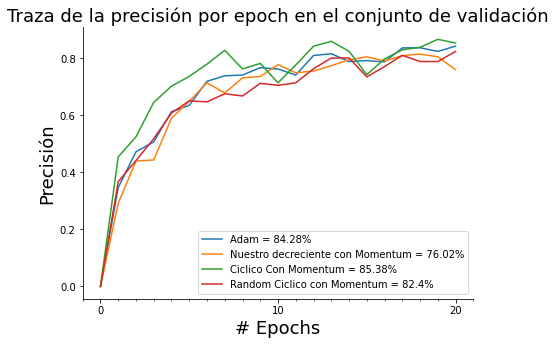

In [106]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

x_axis = range(100)
y_axis = np.linspace(0,5,10)

fig, ax = plt.subplots(figsize=(7, 5))


#Precisiones
for k1, _ in resultados.items():
    ax.plot(range(len(resultados[k1]['val_acc_list'])),
        resultados[k1]['val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados[k1]['name'],
                                       acc = round(resultados[k1]['val_acc_list'][-1] * 100 , 2)))

plt.title('Traza de la precisión por epoch en el conjunto de validación', fontsize = 18)

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Precisión', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

plt.show()

## Traza de costo por epoch

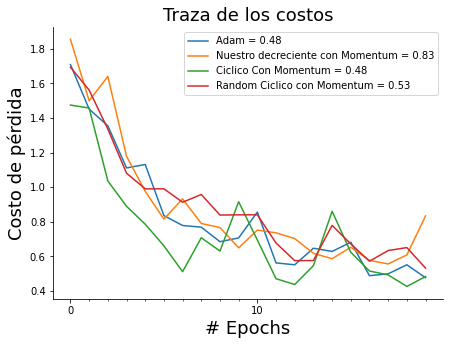

In [107]:
fig, ax = plt.subplots(figsize=(7, 5))

#Costos
for k1, _ in resultados.items():
    ax.plot(range(len(resultados[k1]['cost'])),
        resultados[k1]['cost'],
        label='{name} = {cost}'.format(name= resultados[k1]['name'],
                                       cost = round(resultados[k1]['cost'][-1] , 2)))

plt.title('Traza de los costos', fontsize = 18)

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo de pérdida', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()